# Scoring Elaticsearch Results
### LMI Capstone Team
### Summer Chambers | Steve Morris | Kaleb Shikur

## Setup

In [1]:
import pandas as pd
import numpy as np
import json
import math
from statistics import mode
from sklearn.metrics import ndcg_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
metadata_url = "https://mikeanders.org/data/CMS/CMS-2018-0101-0001/CMS-1701-P%20Comment%20MetaData.csv"
data = pd.read_csv(metadata_url, usecols=range(0,36))[:468] #ignore last few columns and blank rows at end of csv 
data = data.rename(columns=lambda x: x.strip()) #strip whitespace from columns

In [3]:
data10 = data.fillna(0) #fill NaN with 0

section_cols = data10.columns[3:] 
data10[section_cols] = data10[section_cols].replace(["Y"], 1) #replace Y with 1 in approriate columns
data11 = data10.copy()
section_cols1  = data11.columns[3:] 
data11[section_cols1] = np.where((data11[section_cols1]  != 1), 0, data11[section_cols1])

# Combining columns for index matching: (A6b, A6b.1, = A6b),  (C3b, C3b.1'= C3b) ('A7', 'A7.1', 'A7.2', = A7b, a7c),  (F = F2, F3)

data11['A6b'] = (data11['A6b'] + data11['A6b.1'])
data11['A6b'] = data11['A6b'].replace(2,1)
data11['C3b'] = (data11['C3b'] + data11['C3b.1'])
data11['C3b'] = data11['C3b'].replace(2,1)
data11['A7'] = (data11['A7'] + data11['A7.1'] + data11['A7.2'])
data11['A7'] = data11['A7'].replace(2,1)
data11['A7'] = data11['A7'].replace(3,1)

data11 = data11.drop(['A6b.1', 'C3b.1', 'A7.1', 'A7.2'], axis=1)
data11.Name = [name.split('DRAFT-')[1].split('-')[0] for name in data11.Name]
data11 = data11.rename(columns=lambda x: x.lower())
section_cols1 = data11.columns[3:]

In [4]:
data11

,name,organization name / submitter name,submitter state,a2,a3,a4b,a4c,a5b,a5c,a5d,...,d3c,d3d,d4,e2,e3,e4,e5,e6,e7,f
0,0002,Erick Meleher,NC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0003,Mayank Shah,IL,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0004,Mayank Shah,IL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0005,Morey Menacker,NJ,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0006,Todd Rapoza,MA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0465,Morehouse Choice Accountable Care Organization...,GA,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
464,0466,Liberty ACO,TX,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
465,0467,Washington State Hospital Association,WA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466,0468,Think Whole Person Healthcare,NE,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
truth_dict = {} # initiate dict
for i, name in enumerate(data11.name): # iterate through Comment Names
    dict1 = {col:data11[col].iloc[i] for col in section_cols1} # locate this row's values for each column
    list1 = [key for key,value in dict1.items() if value==1] # create list of matching sections for this row
    truth_dict[name] = list1 # add Comment Name and list of matching sections to dict

In [6]:
with open("unique_comments2018.json") as f:
    unique_comments2018 = json.load(f)

In [7]:
unique_data = data11.loc[data11['name'].isin(unique_comments2018.keys())]

In [8]:
unique_truth_dict = {} # initiate dict
for i, name in enumerate(unique_data.name): # iterate through Comment Names
    dict1 = {col:unique_data[col].iloc[i] for col in section_cols1} # locate this row's values for each column
    list1 = [key for key,value in dict1.items() if value==1] # create list of matching sections for this row
    unique_truth_dict[name] = list1 # add Comment Name and list of matching sections to dict

In [9]:
dump = json.dumps(unique_truth_dict)
f = open('unique_truth_dict.json','w')
f.write(dump)
f.close()

In [10]:
#define true rule section names
truth_keys = list(section_cols1)
truth_keys = [key1.lower() for key1 in truth_keys]

## Headers Standard Index Testing

In [11]:
with open('match_header_results.json') as f:
    unique_header_results = json.load(f)

In [12]:
with open('headers_narrowsyn_basestop_results.json') as f:
    headers_narrowsyn_basestop_results = json.load(f)

In [13]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in unique_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        unique_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [14]:
normalized_results = {}
for comment_idx, result in unique_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [15]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [16]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [17]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [18]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [19]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [20]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
unique_header_results_all = unique_header_results.copy()
unique_binary_header_results_all = unique_header_results.copy()
for key, value in unique_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    unique_header_results_all[key] = new_value_list_discounted
    unique_binary_header_results_all[key] = new_value_list_binary

In [21]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
unique_header_results_all = headers_narrowsyn_basestop_results.copy()
unique_binary_header_results_all = headers_narrowsyn_basestop_results.copy()
for key, value in unique_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    unique_header_results_all[key] = new_value_list_discounted
    unique_binary_header_results_all[key] = new_value_list_binary

In [22]:
unique_headers_ndcg = {}
unique_headers_ap = {}
unique_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_header_results_all.items()):
    unique_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    unique_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_binary_header_results_all.items()):
    unique_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [23]:
unique_headers_eval = pd.DataFrame(data=[unique_headers_ndcg, unique_headers_ap, unique_headers_f1]).T
unique_headers_eval = unique_headers_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [24]:
unique_headers_eval.describe()

,NDCG,AP,F1
count,94.000000,94.000000,94.000000
mean,0.497798,0.813862,0.739395
std,0.257016,0.203793,0.104969
min,0.000000,0.068966,0.190476
25%,0.321587,0.767370,0.731707
50%,0.502037,0.893465,0.765957
75%,0.679465,0.958766,0.791667
max,0.993542,1.000000,0.863636


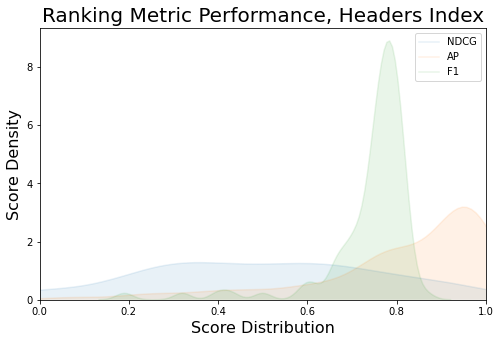

In [25]:
plt.figure(figsize = (8,5))
sns.kdeplot(unique_headers_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(unique_headers_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(unique_headers_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Headers Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

### Which comments were scored poorly?

In [26]:
with open('expanded.json') as f1:
    comments = json.load(f1)

In [27]:
unique_headers_eval.query("NDCG == 0")

,NDCG,AP,F1
0110,0.0,1.0,0.791667
0126,0.0,1.0,0.791667
0240,0.0,1.0,0.791667
0256,0.0,1.0,0.791667
0287,0.0,1.0,0.791667
0408,0.0,1.0,0.791667
0467,0.0,1.0,0.791667


In [28]:
poorf1 = unique_headers_eval.query("F1 < 0.5").F1
#poorf1

In [29]:
poorndcg = unique_headers_eval.query("NDCG < 0.3 & NDCG > 0").NDCG
#poorndcg

In [30]:
poorf1_comments = {key:comment for key, comment in comments.items() if key[0:4] in poorf1}
#{key:len(comment) for key, comment in poorf1_comments.items()}

In [31]:
poorf1_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorf1}
#poorf1_comments_truth

In [32]:
poorndcg_comments = {key:comment for key, comment in comments.items() if key in poorndcg}
#{key:len(comment) for key, comment in poorndcg_comments.items()}

In [33]:
poorndcg_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorndcg}
#poorndcg_comments_truth

## Headers Custom Index Testing

In [34]:
with open('match_header_custom_results.json') as f:
    custom_header_results = json.load(f)

In [35]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [36]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [37]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [38]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [39]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [40]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [41]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [42]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [43]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [44]:
custom_headers_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
custom_headers_eval = custom_headers_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [45]:
custom_headers_eval.describe()

,NDCG,AP,F1
count,94.000000,94.000000,94.000000
mean,0.497073,0.813809,0.737069
std,0.257272,0.201831,0.107658
min,0.000000,0.068966,0.190476
25%,0.296737,0.767898,0.739130
50%,0.514547,0.889115,0.765957
75%,0.691605,0.956577,0.791667
max,0.993542,1.000000,0.863636


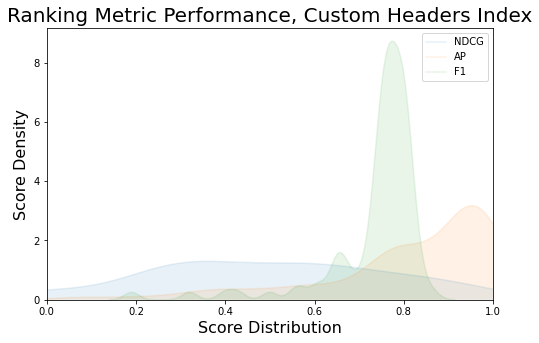

In [46]:
plt.figure(figsize = (8,5))
sns.kdeplot(custom_headers_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(custom_headers_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(custom_headers_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Custom Headers Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

## Hybrid Standard Index Testing

In [47]:
with open('match_hybrid_results.json') as f1:
    unique_hybrid_results = json.load(f1)

In [48]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in unique_hybrid_results.items():
    value_list = []
    for val_idx in value:
        for true_key in truth_keys:
            if true_key in val_idx[0:4]:
                    value_list.append(true_key)
        unique_hybrid_results[key]=[(true_key, score) for (val_idx, score), true_key in zip(value.items(),value_list)]

In [49]:
for comment_idx, tup_list in unique_hybrid_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    unique_hybrid_results[comment_idx] = score_dict

### Normalize scores (divide by mean)

In [50]:
normalized_results = {}
for comment_idx, result in unique_hybrid_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [51]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [52]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [53]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [54]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [55]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [56]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
unique_hybrid_results_all = unique_hybrid_results.copy()
unique_binary_hybrid_results_all = unique_hybrid_results.copy()
for key, value in unique_hybrid_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    unique_hybrid_results_all[key] = new_value_list_discounted
    unique_binary_hybrid_results_all[key] = new_value_list_binary

In [57]:
unique_hybrid_ndcg = {}
unique_hybrid_ap = {}
unique_hybrid_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_hybrid_results_all.items()):
    unique_hybrid_ndcg[true_key] = ndcg_score([true_value], [es_value])
    unique_hybrid_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_binary_hybrid_results_all.items()):
    unique_hybrid_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [58]:
unique_hybrid_eval = pd.DataFrame(data=[unique_hybrid_ndcg, unique_hybrid_ap, unique_hybrid_f1]).T
unique_hybrid_eval = unique_hybrid_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [59]:
unique_hybrid_eval.describe()

,NDCG,AP,F1
count,94.000000,94.000000,94.000000
mean,0.469845,0.822173,0.814973
std,0.251079,0.195252,0.141223
min,0.000000,0.068966,0.153846
25%,0.255925,0.759264,0.808511
50%,0.463493,0.918435,0.862745
75%,0.645953,0.970443,0.884615
max,0.989322,1.000000,0.943396


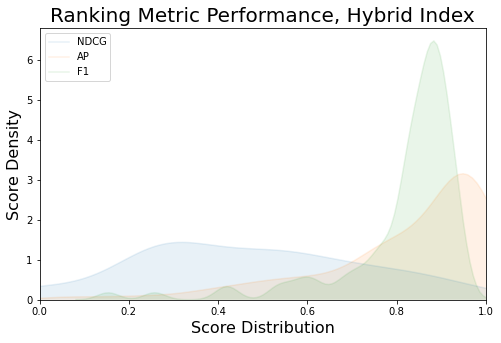

In [60]:
plt.figure(figsize = (8,5))
sns.kdeplot(unique_hybrid_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(unique_hybrid_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(unique_hybrid_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Hybrid Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

### Which comments were scored poorly?

In [61]:
with open('expanded.json') as f1:
    comments = json.load(f1)

In [62]:
unique_hybrid_eval.query("NDCG == 0")

,NDCG,AP,F1
0110,0.0,1.0,0.905660
0126,0.0,1.0,0.925926
0240,0.0,1.0,0.925926
0256,0.0,1.0,0.925926
0287,0.0,1.0,0.925926
0408,0.0,1.0,0.905660
0467,0.0,1.0,0.925926


In [63]:
poorf1 = unique_hybrid_eval.query("F1 < 0.5").F1
#poorf1

In [64]:
poorndcg = unique_hybrid_eval.query("NDCG < 0.3 & NDCG > 0").NDCG
#poorndcg

In [65]:
poorf1_comments = {key:comment for key, comment in comments.items() if key[0:4] in poorf1}
#{key:len(comment) for key, comment in poorf1_comments.items()}

In [66]:
poorf1_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorf1}
#poorf1_comments_truth

In [67]:
poorndcg_comments = {key:comment for key, comment in comments.items() if key in poorndcg}
#{key:len(comment) for key, comment in poorndcg_comments.items()}

In [68]:
poorndcg_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorndcg}
#poorndcg_comments_truth

## Hybrid Custom Index Testing

In [69]:
with open('match_hybrid_custom_results.json') as f1:
    custom_hybrid_results = json.load(f1)

In [70]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_hybrid_results.items():
    value_list = []
    for val_idx in value:
        for true_key in truth_keys:
            if true_key in val_idx[0:4]:
                    value_list.append(true_key)
        custom_hybrid_results[key]=[(true_key, score) for (val_idx, score), true_key in zip(value.items(),value_list)]

In [71]:
for comment_idx, tup_list in custom_hybrid_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    custom_hybrid_results[comment_idx] = score_dict

### Normalize scores (divide by mean)

In [72]:
normalized_results = {}
for comment_idx, result in custom_hybrid_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [73]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [74]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [75]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [76]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [77]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [78]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_hybrid_results_all = custom_hybrid_results.copy()
custom_binary_hybrid_results_all = custom_hybrid_results.copy()
for key, value in custom_hybrid_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_hybrid_results_all[key] = new_value_list_discounted
    custom_binary_hybrid_results_all[key] = new_value_list_binary

In [79]:
custom_hybrid_ndcg = {}
custom_hybrid_ap = {}
custom_hybrid_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_hybrid_results_all.items()):
    custom_hybrid_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_hybrid_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_hybrid_results_all.items()):
    custom_hybrid_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [80]:
custom_hybrid_eval = pd.DataFrame(data=[custom_hybrid_ndcg, custom_hybrid_ap, custom_hybrid_f1]).T
custom_hybrid_eval = custom_hybrid_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [81]:
custom_hybrid_eval.describe()

,NDCG,AP,F1
count,94.000000,94.000000,94.000000
mean,0.470008,0.820358,0.811708
std,0.251510,0.198791,0.144005
min,0.000000,0.068966,0.160000
25%,0.259803,0.747607,0.793750
50%,0.445664,0.913698,0.862745
75%,0.641214,0.970135,0.884615
max,0.990397,1.000000,0.962963


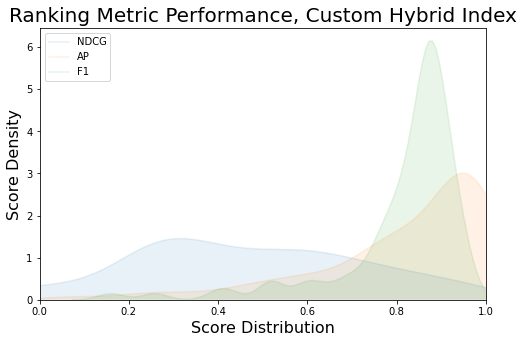

In [82]:
plt.figure(figsize = (8,5))
sns.kdeplot(custom_hybrid_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(custom_hybrid_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(custom_hybrid_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Custom Hybrid Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

## Compare different indices

In [83]:
df_list = [unique_headers_eval, custom_headers_eval, unique_hybrid_eval, custom_hybrid_eval]
mean_df_list = [df.mean() for df in df_list]

In [84]:
comparison = pd.DataFrame(mean_df_list).T.rename({i:df for i, df in enumerate(["Std Hdr", "Cst Hdr", "Std Hyb", "Cst Hyb"])},\
                                                 axis=1).rename({"AP":"MAP"})
comparison

,Std Hdr,Cst Hdr,Std Hyb,Cst Hyb
NDCG,0.497798,0.497073,0.469845,0.470008
MAP,0.813862,0.813809,0.822173,0.820358
F1,0.739395,0.737069,0.814973,0.811708


## Headers Narrow-Syn Base-Stop Index Testing

In [85]:
with open('headers_narrowsyn_basestop_results.json') as f:
    custom_header_results = json.load(f)

In [86]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [87]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [88]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [89]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [90]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [91]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [92]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [93]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [94]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [95]:
headers_narrowsyn_basestop_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
headers_narrowsyn_basestop_eval = headers_narrowsyn_basestop_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [96]:
headers_narrowsyn_basestop_eval.mean()

NDCG    0.502639
AP      0.813529
F1      0.739111
dtype: float64

## Headers Narrow-Syn Custom-Stop Index Testing

In [97]:
with open('headers_narrowsyn_custstop_results.json') as f:
    custom_header_results = json.load(f)

In [98]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [99]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [100]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [101]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [102]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [103]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [104]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [105]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [106]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [107]:
headers_narrowsyn_custstop_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
headers_narrowsyn_custstop_eval = headers_narrowsyn_custstop_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [108]:
headers_narrowsyn_custstop_eval.mean()

NDCG    0.500934
AP      0.812287
F1      0.739617
dtype: float64

## Headers No-Syn Custom-Stop Index Testing

In [109]:
with open('headers_nosyn_custstop_results.json') as f:
    custom_header_results = json.load(f)

In [110]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [111]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [112]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [113]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [114]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [115]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [116]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [117]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [118]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [119]:
headers_nosyn_custstop_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
headers_nosyn_custstop_eval = headers_nosyn_custstop_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [120]:
headers_nosyn_custstop_eval.mean()

NDCG    0.469274
AP      0.809978
F1      0.876925
dtype: float64

### !

## Headers exp-Syn Base-Stop Index Testing

In [121]:
with open('headers_expsyn_basestop_results.json') as f:
    custom_header_results = json.load(f)

In [122]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [123]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [124]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [125]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [126]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [127]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [128]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [129]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [130]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [131]:
headers_expsyn_basestop_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
headers_expsyn_basestop_eval = headers_expsyn_basestop_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [132]:
headers_expsyn_basestop_eval.mean()

NDCG    0.469274
AP      0.809978
F1      0.876925
dtype: float64

## Headers exp-Syn Custom-Stop Index Testing

In [133]:
with open('headers_expsyn_customstop_results.json') as f:
    custom_header_results = json.load(f)

In [134]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [135]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [136]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [137]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [138]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [139]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [140]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [141]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [142]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [143]:
headers_expsyn_customstop_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
headers_expsyn_customstop_eval = headers_expsyn_customstop_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [144]:
headers_expsyn_customstop_eval.mean()

NDCG    0.498635
AP      0.813643
F1      0.738559
dtype: float64

## Headers Broad-Syn Base-Stop Index Testing

In [145]:
with open('headers_broadsyn_basestop_results.json') as f:
    custom_header_results = json.load(f)

In [146]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [147]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [148]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [149]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [150]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [151]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [152]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [153]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [154]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [155]:
headers_broadsyn_basesstop_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
headers_broadsyn_basesstop_eval = headers_broadsyn_basesstop_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [156]:
headers_broadsyn_basesstop_eval.mean()

NDCG    0.497073
AP      0.813809
F1      0.737069
dtype: float64

## Headers Broad-Syn Custom-Stop Index Testing

In [157]:
with open('headers_broadsyn_custstop_results.json') as f:
    custom_header_results = json.load(f)

In [158]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [159]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [160]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [161]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [162]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [163]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [164]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [165]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [166]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [167]:
headers_broadsyn_custstop_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
headers_broadsyn_custstop_eval = headers_broadsyn_custstop_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [168]:
headers_broadsyn_custstop_eval.mean()

NDCG    0.497247
AP      0.812751
F1      0.736553
dtype: float64

## Headers No-Synonym Base-Stop Index Testing

In [169]:
with open('headers_nosyn_basestop_results.json') as f:
    custom_header_results = json.load(f)

In [170]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [171]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [172]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [173]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [174]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [175]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [176]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [177]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [178]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [180]:
headers_nosyn_basestop_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
headers_nosyn_basestop_eval = headers_nosyn_basestop_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [181]:
headers_nosyn_basestop_eval.mean()

NDCG    0.503582
AP      0.813228
F1      0.737496
dtype: float64

# Synonym from comments included

## Headers No-Synonym Base-Stop Index Testing

In [193]:
with open('headers_expsyn_comsyn_basestop_results.json') as f:
    custom_header_results = json.load(f)

In [194]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [195]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [196]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [197]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [198]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [199]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [200]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [201]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [202]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [203]:
headers_expsyn_comsyn_basestop = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
headers_expsyn_comsyn_basestop = headers_expsyn_comsyn_basestop.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [204]:
headers_expsyn_comsyn_basestop.mean()

NDCG    0.498861
AP      0.815055
F1      0.735647
dtype: float64

## Updated: "Grid Search" Compare different indices

In [205]:
df_list = [headers_narrowsyn_basestop_eval, headers_narrowsyn_custstop_eval, headers_nosyn_custstop_eval, \
           headers_expsyn_basestop_eval, headers_expsyn_customstop_eval, headers_broadsyn_basesstop_eval, \
          headers_broadsyn_custstop_eval, headers_nosyn_basestop_eval, headers_expsyn_comsyn_basestop]
mean_df_list = [df.mean() for df in df_list]

In [206]:
comparison = pd.DataFrame(mean_df_list).T.rename({i:df for i, df in enumerate(["Narrow-Base", "Narrow-Cust", \
                                                                               "No-Cust", "Exp-Base", "Exp-Cust", \
                                                                              "Broad-Base", "Broad-Cust", "No-Base", "Exp-Comment-Base"])},\
                                                 axis=1).rename({"AP":"MAP"})
#print(comparison.MAP.max())
print(comparison.columns[np.argmax(comparison.T.MAP)])

Exp-Comment-Base


In [207]:
comparison

,Narrow-Base,Narrow-Cust,No-Cust,Exp-Base,Exp-Cust,Broad-Base,Broad-Cust,No-Base,Exp-Comment-Base
NDCG,0.502639,0.500934,0.469274,0.469274,0.498635,0.497073,0.497247,0.503582,0.498861
MAP,0.813529,0.812287,0.809978,0.809978,0.813643,0.813809,0.812751,0.813228,0.815055
F1,0.739111,0.739617,0.876925,0.876925,0.738559,0.737069,0.736553,0.737496,0.735647


# Defining a Score_Results Function

In [ ]:
score_headers_results

In [211]:
def score_headers_results(json_file): #takes .json result as input, gives pandas eval df as output
    #open file
    with open(json_file) as f:
        custom_header_results = json.load(f)
    
    #tranlate ES keys to true rule section names, MAINTAINING ORDER
    for key, value in custom_header_results.items():
        value_list = []
        for val_idx, score in value.items():
            for true_key in truth_keys:
                if true_key in val_idx and true_key not in value_list: 
                    value_list.append(true_key)
            custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     
    
    #Normalize results by dividing by mean
    normalized_results = {}
    for comment_idx, result in custom_header_results.items():
        score_mean = np.mean(list(result.values()))
        score_dict = {}
        for rule_idx, score in result.items():
            score_dict[rule_idx] = score/score_mean
        normalized_results[comment_idx] = score_dict
    normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}
    
    #Merge results back together
    merged_results = {}
    for key in unique_truth_dict.keys():
        merged_list = []
        for comment_idx, result_list in normalized_lists.items():
            if key in comment_idx:
                merged_list.extend(result_list)
        merged_results[key] = merged_list
    merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}
    for comment_idx, tup_list in merged_results.items():
        score_dict = {}
        for tup in tup_list:
            if tup[0] in score_dict.keys():
                score_dict[tup[0]] += tup[1]
            else:
                score_dict[tup[0]] = tup[1]
        merged_results[comment_idx] = score_dict
    merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True)) for comment_idx, result in merged_results.items()}
    
    #create truth dict with values equal to sparse array length=29, binary
    unique_truth_dict_all = unique_truth_dict.copy()
    for key, value in unique_truth_dict.items():
        new_value_list = np.zeros(len(truth_keys))
        for val in value:
            for i in range(len(truth_keys)):
                if val == truth_keys[i]:
                    new_value_list[i] = 1
        unique_truth_dict_all[key] = new_value_list
    
    #create header results dict with values equal to sparse array length=29, (discounted and binary versions)
    custom_header_results_all = custom_header_results.copy()
    custom_binary_header_results_all = custom_header_results.copy()
    for key, value in custom_header_results.items():
        new_value_list_discounted = np.zeros(len(truth_keys))
        new_value_list_binary = np.zeros(len(truth_keys))
        counter = 1
        for rule_section in value.keys():
            for i in range(len(truth_keys)):
                if rule_section == truth_keys[i]:
                    counter += 1
                    new_value_list_discounted[i] = 1/math.log(counter, 2)
                    new_value_list_binary[i] = 1
        custom_header_results_all[key] = new_value_list_discounted
        custom_binary_header_results_all[key] = new_value_list_binary
    
    #Get NDCG, AP, F1 with SKlearn
    custom_headers_ndcg = {}
    custom_headers_ap = {}
    custom_headers_f1 = {}
    for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
        custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
        custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
    for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
        custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)
    headers_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
    headers_eval = headers_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)
    return headers_eval